# Jan 22nd, 2022 (degree dist, cartography)

**Motivation**: Look at degree distributions, both weighted and nonweighted, at various densities.  Also compare BOLD vs. Ca degree and entropy.  Eventually, make cartography figure.  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, idx: int = 0, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(1, 4, (10., 2), gridspec_kw={'width_ratios': [1.8, 1, 1, 1.8]})

    x2plt = proj_h['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

## K = 5

In [4]:
props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

In [5]:
gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group(skip_align=False)
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group(skip_align=False)

gr_ca.pi = gr_ca.grp_pi
gr_bold.pi = gr_bold.grp_pi

proj_ca = gr_ca.project_vec()
proj_bold = gr_bold.project_vec()

### Membership plot

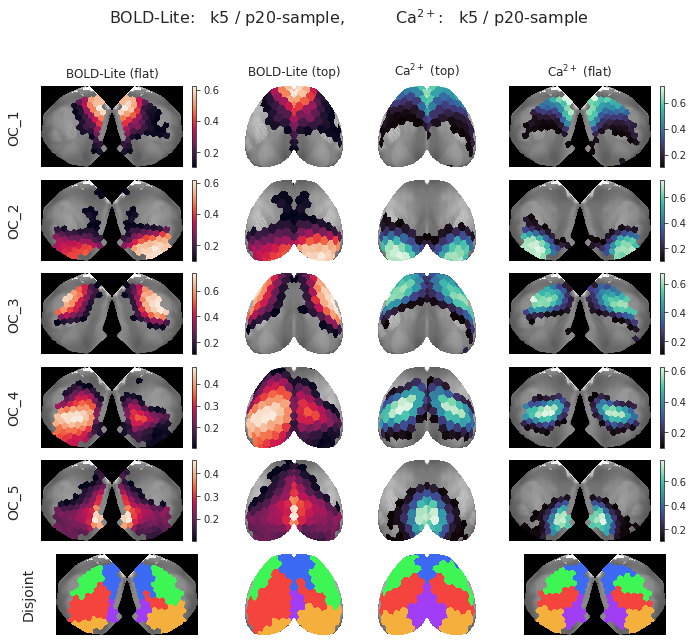

In [6]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

### Entropy plot

In [7]:
proj_h_bold = gr_bold.project_vec(gr_bold.grp_h, add_disjoint=False)
proj_hr_bold = gr_bold.project_vec(gr_bold.grp_hr, add_disjoint=False)

proj_h_ca = gr_ca.project_vec(gr_ca.grp_h, add_disjoint=False)
proj_hr_ca = gr_ca.project_vec(gr_ca.grp_hr, add_disjoint=False)

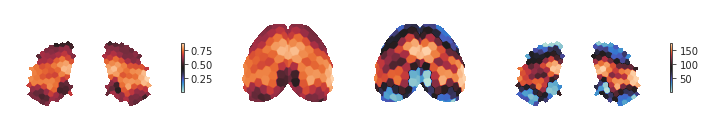

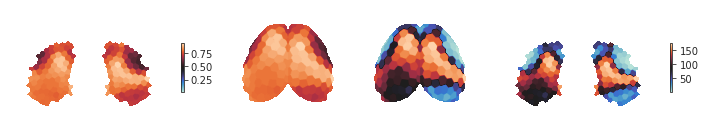

In [8]:
show_h(proj_h_ca, proj_hr_ca)
show_h(proj_h_bold, proj_hr_bold)

## Fig 2 (nodes)

### d = 20 %

In [9]:
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [10]:
# HIDE CODE

theta_all = collections.defaultdict(dict)
dlist1, dlist2 = [], []
for k in [3, 4, 5, 6]:
    props = props_base.copy()
    props['num_k'] = k

    props_ca = {'perc': 'p20-sample', **props}
    props_bold = {'perc': 'p20-sample', **props}
    
    # Group results
    _gr_ca = Group(
        mode='ca2',
        centroids_from='runs',
        **props_ca,
    ).fit_group(skip_align=False)
    _gr_bold = Group(
        mode='bold-lite',
        centroids_from='runs',
        **props_bold,
    ).fit_group(skip_align=False)

    theta_ca, maxmem_ca = compute_theta(_gr_ca.run_gam)
    theta_bold, maxmem_bold = compute_theta(_gr_bold.run_gam)
    
    maxmem = {
        'ca2': maxmem_ca.ravel(),
        'bold-lite': maxmem_bold.ravel(),
    }
    for mode, x in maxmem.items():
        dlist1.append({
            'maxmem': x,
            'K': [k] * len(x),
            'mode': [mode] * len(x),
        })

    theta = {
        'ca2': bn.nanmean(bn.nanmean(theta_ca, -1), -1),
        'bold-lite': bn.nanmean(bn.nanmean(theta_bold, -1), -1),
    }
    for mode, x in theta.items():
        dlist2.append({
            'theta': x,
            'K': [k] * len(x),
            'mode': [mode] * len(x),
            'animal': range(1, len(x) + 1),
        })
    theta_all[k] = theta
df1 = pd.DataFrame(merge_dicts(dlist1))
df2 = pd.DataFrame(merge_dicts(dlist2))

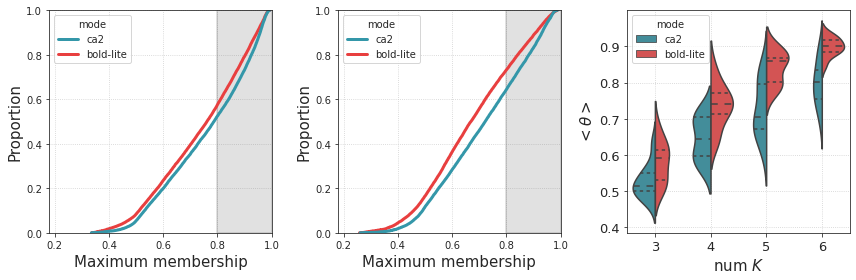

In [11]:
# HIDE CODE


fig, axes = create_figure(1, 3, (12, 4))

for ax, k in zip(axes[:2], [3, 4, 5]):
    ax.axvspan(
        xmin=0.8,
        xmax=1.0,
        lw=2,
        alpha=0.2,
        color='dimgrey',
        label='Disjoint zone',
    )
    sns.ecdfplot(
        data=df1.loc[df1['K'] == k],
        x='maxmem',
        hue='mode',
        palette=pal,
        lw=3,
        ax=ax,
    )
    ax.set_ylabel(r'Proportion', fontsize=15)
    ax.set_xlabel(r'Maximum membership', fontsize=15)
    ax.set_xlim(0.18, 1.0)
    ax.grid()

ax = axes[-1]
sns.violinplot(
    data=df2,
    x='K',
    y='theta',
    hue='mode',
    inner="quartile",
    palette=pal,
    split=True,
    ax=ax,
)
ax.set_ylabel(r'$<\theta>$', fontsize=15)
ax.set_xlabel(r'num $K$', fontsize=15)
ax.tick_params('both', labelsize=13)
ax.grid()

plt.show()

### d = 10 %

In [12]:
# HIDE CODE

theta_all = collections.defaultdict(dict)
dlist1, dlist2 = [], []
for k in [3, 4, 5, 6]:
    props = props_base.copy()
    props['num_k'] = k

    props_ca = {'perc': 'p10-sample', **props}
    props_bold = {'perc': 'p10-sample', **props}
    
    # Group results
    _gr_ca = Group(
        mode='ca2',
        centroids_from='runs',
        **props_ca,
    ).fit_group(skip_align=False)
    _gr_bold = Group(
        mode='bold-lite',
        centroids_from='runs',
        **props_bold,
    ).fit_group(skip_align=False)

    theta_ca, maxmem_ca = compute_theta(_gr_ca.run_gam)
    theta_bold, maxmem_bold = compute_theta(_gr_bold.run_gam)
    
    maxmem = {
        'ca2': maxmem_ca.ravel(),
        'bold-lite': maxmem_bold.ravel(),
    }
    for mode, x in maxmem.items():
        dlist1.append({
            'maxmem': x,
            'K': [k] * len(x),
            'mode': [mode] * len(x),
        })

    theta = {
        'ca2': bn.nanmean(bn.nanmean(theta_ca, -1), -1),
        'bold-lite': bn.nanmean(bn.nanmean(theta_bold, -1), -1),
    }
    for mode, x in theta.items():
        dlist2.append({
            'theta': x,
            'K': [k] * len(x),
            'mode': [mode] * len(x),
            'animal': range(1, len(x) + 1),
        })
    theta_all[k] = theta
df1 = pd.DataFrame(merge_dicts(dlist1))
df2 = pd.DataFrame(merge_dicts(dlist2))

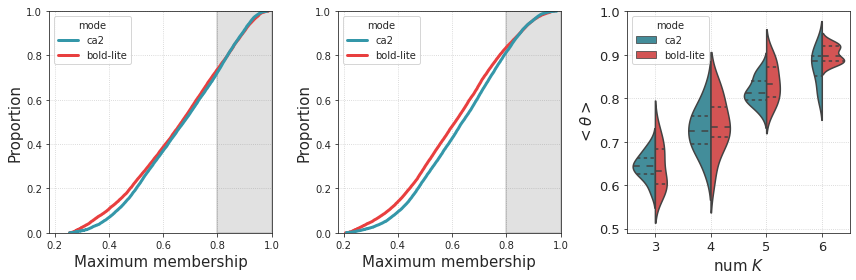

In [13]:
# HIDE CODE


fig, axes = create_figure(1, 3, (12, 4))

for ax, k in zip(axes[:2], [4, 5]):
    ax.axvspan(
        xmin=0.8,
        xmax=1.0,
        lw=2,
        alpha=0.2,
        color='dimgrey',
        label='Disjoint zone',
    )
    sns.ecdfplot(
        data=df1.loc[df1['K'] == k],
        x='maxmem',
        hue='mode',
        palette=pal,
        lw=3,
        ax=ax,
    )
    ax.set_ylabel(r'Proportion', fontsize=15)
    ax.set_xlabel(r'Maximum membership', fontsize=15)
    ax.set_xlim(0.18, 1.0)
    ax.grid()

ax = axes[-1]
sns.violinplot(
    data=df2,
    x='K',
    y='theta',
    hue='mode',
    inner="quartile",
    palette=pal,
    split=True,
    ax=ax,
)
ax.set_ylabel(r'$<\theta>$', fontsize=15)
ax.set_xlabel(r'num $K$', fontsize=15)
ax.tick_params('both', labelsize=13)
ax.grid()

plt.show()

## Degree

In [14]:
%%time

df_deg = pd.concat([
    make_degree_df(mice, 'bold-lite'),
    make_degree_df(mice, 'ca2'),
])
df_deg.reset_index(drop=True, inplace=True)

CPU times: user 32.4 s, sys: 979 ms, total: 33.4 s
Wall time: 33.5 s


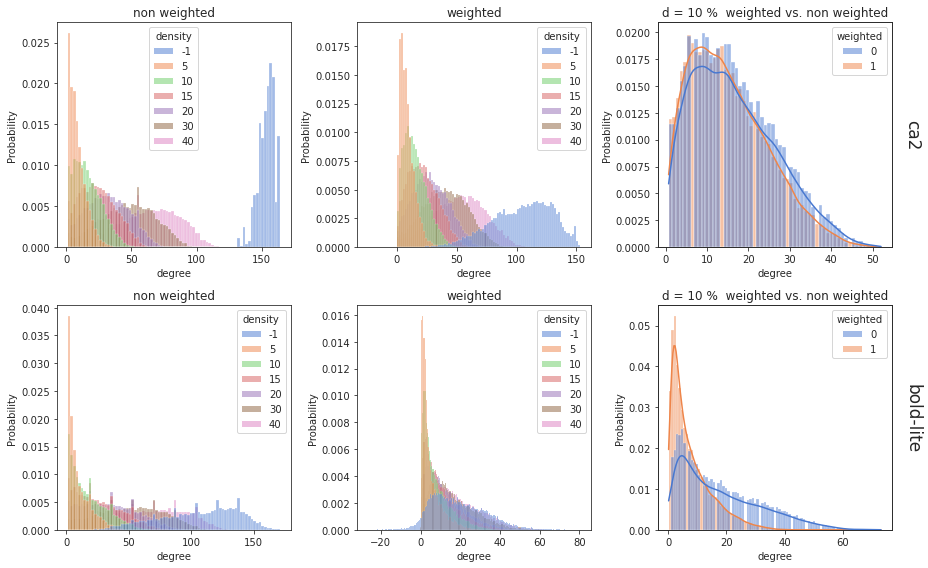

In [15]:
fig, axes = create_figure(2, 3, (13, 8))

for i, mode in enumerate(['ca2', 'bold-lite']):
    _df = df_deg.loc[
        (df_deg['mode']== mode) &
        (df_deg['weighted']== 0)
    ]
    sns.histplot(
        data=_df,
        x='degree',
        hue='density',
        palette='muted',
        stat='probability',
        ax=axes[i, 0],
    )
    axes[i, 0].set_title(f"non weighted")

    _df = df_deg.loc[
        (df_deg['mode']== mode) &
        (df_deg['weighted']== 1)
    ]
    sns.histplot(
        data=_df,
        x='degree',
        hue='density',
        palette='muted',
        stat='probability',
        ax=axes[i,1],
    )
    axes[i, 1].set_title(f"weighted")

    _df = df_deg.loc[
        (df_deg['mode']== mode) &
        (df_deg['density']== 10)
    ]
    sns.histplot(
        data=_df,
        kde=True,
        x='degree',
        hue='weighted',
        palette='muted',
        stat='probability',
        ax=axes[i, 2],
    )
    axes[i, 2].set_title(f"d = 10 %  weighted vs. non weighted")
    
    axtw = axes[i, 2].twinx()
    axtw.set_ylabel(mode, fontsize=17, rotation=-90, labelpad=30)
    axtw.yaxis.set_label_position("right")
    axtw.set_yticks([])

plt.show()

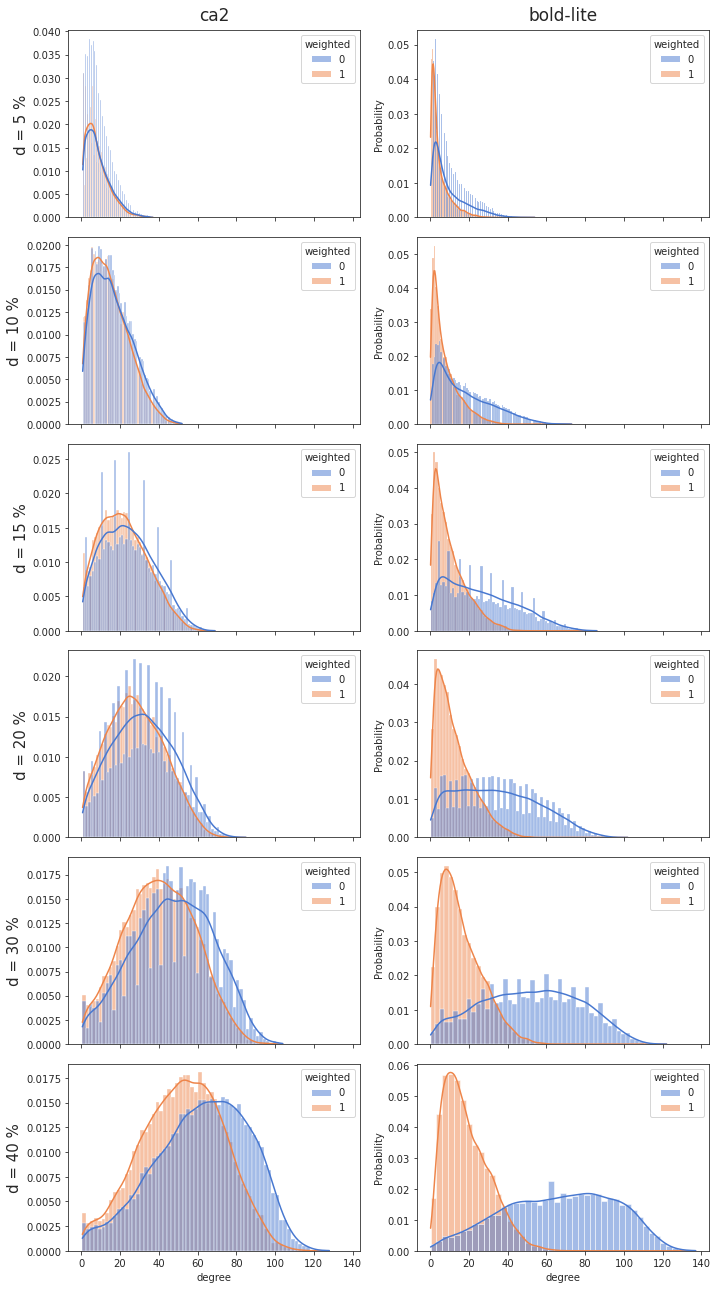

In [16]:
densities = [d for d in df_deg['density'].unique() if d > 0]
fig, axes = create_figure(len(densities), 2, (10, 18), sharex='all')

for i, mode in enumerate(['ca2', 'bold-lite']):
    for ax, d in zip(axes[:, i], densities):
        _df = df_deg.loc[
            (df_deg['mode']== mode) &
            (df_deg['density']== d)
        ]
        sns.histplot(
            data=_df,
            kde=True,
            x='degree',
            hue='weighted',
            palette='muted',
            stat='probability',
            ax=ax,
        )
        if d == densities[0]:
            ax.set_title(mode, fontsize=17, y=1.02)
        if i == 0:
            ax.set_ylabel(f"d = {d} %", fontsize=15)
plt.show()

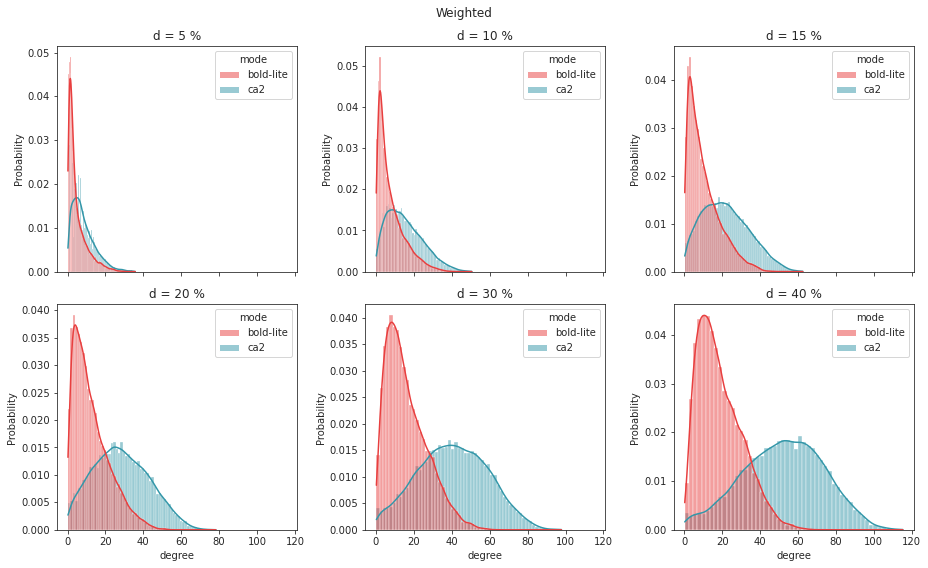

In [17]:
fig, axes = create_figure(2, 3, (13, 8), sharex='all')

densities = [d for d in df_deg['density'].unique() if d > 0]
for ax, d in zip(axes.flat, densities):
    _df = df_deg.loc[
        (df_deg['density']== d) &
        (df_deg['weighted'] == 1)
    ]
    sns.histplot(
        data=_df,
        kde=True,
        x='degree',
        hue='mode',
        palette=pal,
        stat='probability',
        ax=ax,
    )
    ax.set_title(f"d = {d} %")
fig.suptitle('Weighted')
plt.show()

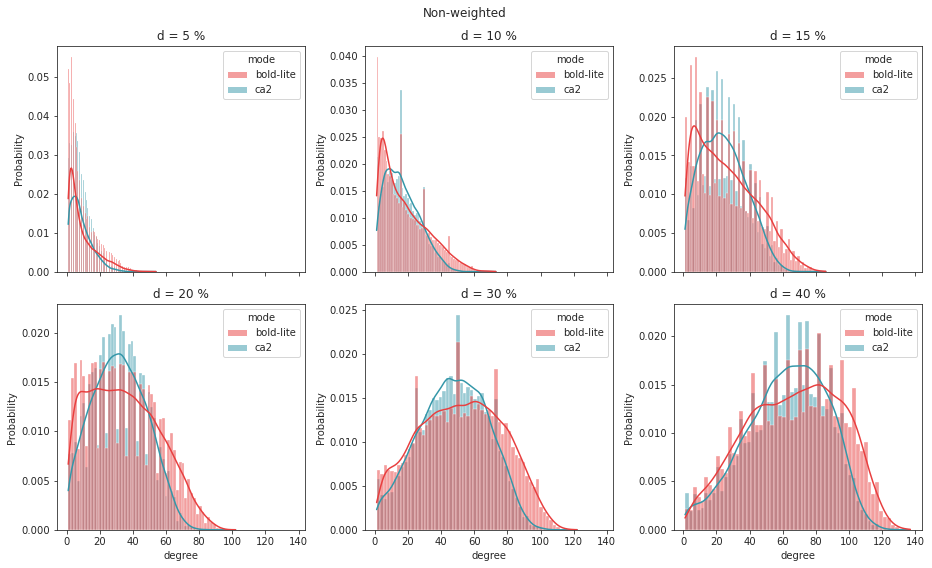

In [18]:
fig, axes = create_figure(2, 3, (13, 8), sharex='all')

densities = [d for d in df_deg['density'].unique() if d > 0]
for ax, d in zip(axes.flat, densities):
    _df = df_deg.loc[
        (df_deg['density']== d) &
        (df_deg['weighted'] == 0)
    ]
    sns.histplot(
        data=_df,
        kde=True,
        x='degree',
        hue='mode',
        palette=pal,
        stat='probability',
        ax=ax,
    )
    ax.set_title(f"d = {d} %")
fig.suptitle('Non-weighted')
plt.show()

## Fitter

In [19]:
mode = 'bold-lite'
sub, ses, run = 7, 1, 3
_df = df_deg.loc[
    (df_deg['weighted'] == 1) &
    (df_deg['density'] == 20) &
    (df_deg['mode'] == mode) &
    (df_deg['sub'] == sub) &
    (df_deg['ses'] == ses) &
    (df_deg['run'] == run)
]

<AxesSubplot:ylabel='Count'>

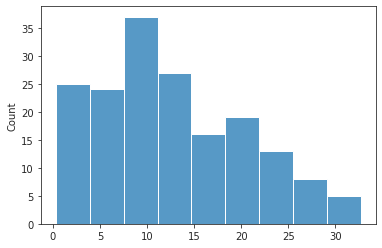

In [170]:
sns.histplot(_df['degree'].values)

In [267]:
mode = 'ca2'
_df = df_deg.loc[
    (df_deg['weighted'] == 1) &
    (df_deg['density'] == 20) &
    (df_deg['mode'] == mode)
]

<AxesSubplot:ylabel='Count'>

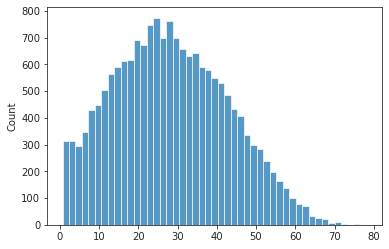

In [268]:
data = _df['degree'].values
data = data[np.isfinite(data)]
sns.histplot(data)

In [191]:
f = Fitter(data, timeout=2000)
f.fit(progress=True)

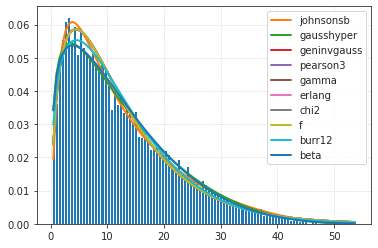

In [194]:
perf = f.summary(Nbest=10)

In [195]:
perf

sumsquare_error 
 aic 
 bic 
 kl_div 
 
 
 
 
 johnsonsb 
 0.000392 
 1012.448387 
 -349234.727054 
 inf 
 
 
 gausshyper 
 0.000544 
 1018.955533 
 -342741.709408 
 inf 
 
 
 geninvgauss 
 0.000554 
 970.800559 
 -342417.910257 
 inf 
 
 
 pearson3 
 0.000554 
 968.811661 
 -342415.440361 
 inf 
 
 
 gamma 
 0.000554 
 968.812837 
 -342414.739732 
 inf 
 
 
 erlang 
 0.000554 
 968.812966 
 -342414.538197 
 inf 
 
 
 chi2 
 0.000554 
 968.814375 
 -342414.157052 
 inf 
 
 
 f 
 0.000554 
 970.819581 
 -342398.719689 
 inf 
 
 
 burr12 
 0.000573 
 980.670911 
 -341744.549577 
 inf 
 
 
 beta 
 0.000596 
 1001.202468 
 -340977.656979 
 inf

In [215]:
_df = df_deg.loc[
    (df_deg['weighted'] == 0) &
    (df_deg['density'] == 20) &
    (df_deg['node'] == 5)
]

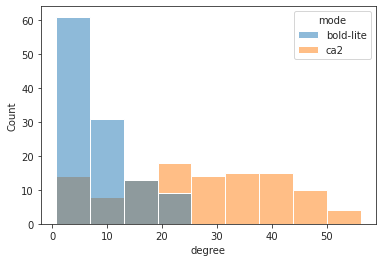

In [214]:
sns.histplot(data=_df, x='degree', hue='mode')
plt.show()

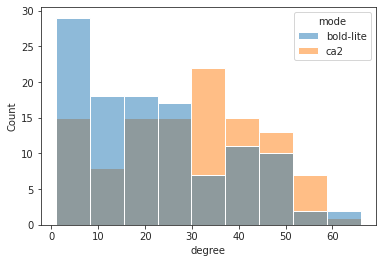

In [216]:
sns.histplot(data=_df, x='degree', hue='mode')
plt.show()

## Ca-BOLD similarity

In [20]:
props_base = {
    'num_k': 4,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group(skip_align=False)
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group(skip_align=False)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

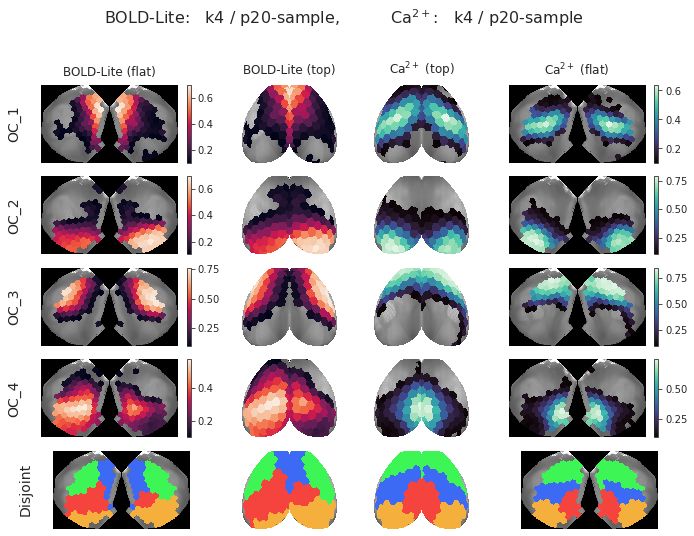

In [21]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

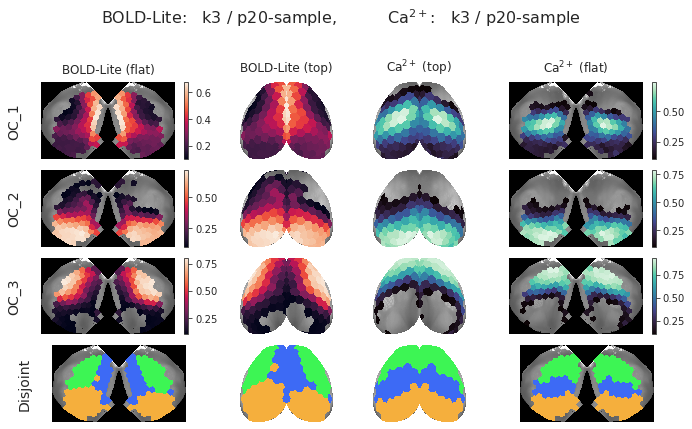

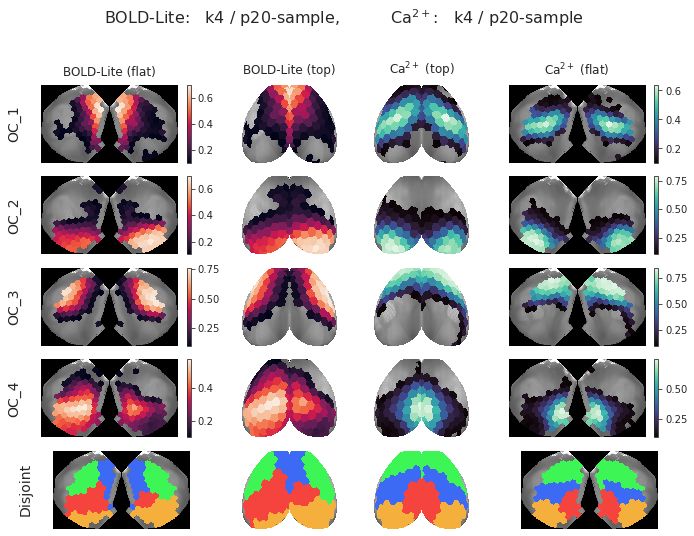

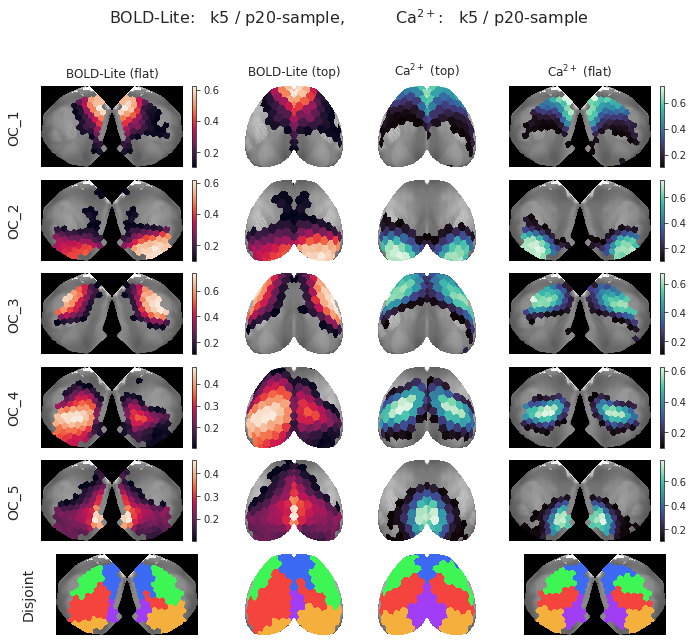

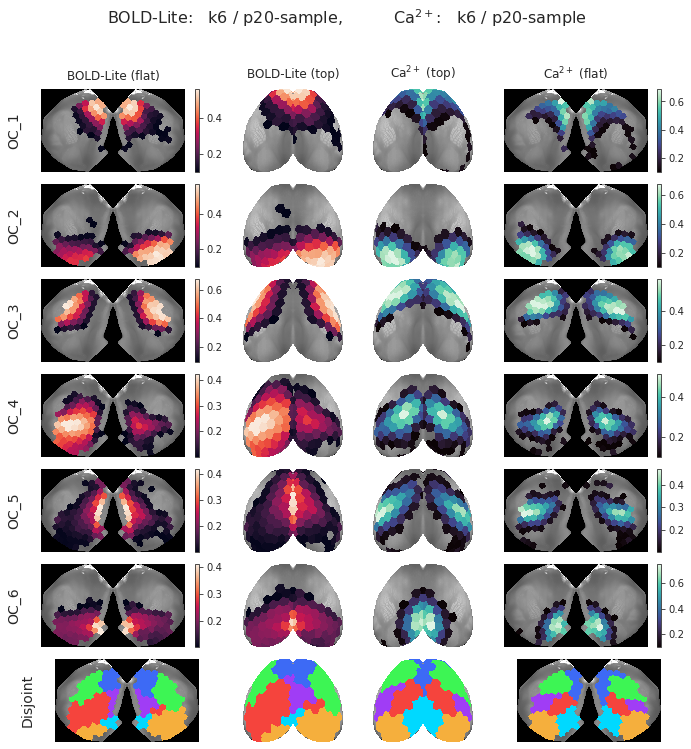

In [22]:
for k in [3, 4, 5, 6]:
    props = props_base.copy()
    props['num_k'] = k

    props_ca = {'perc': 'p20-sample', **props}
    props_bold = {'perc': 'p20-sample', **props}

    # Group results
    _gr_ca = Group(
        mode='ca2',
        centroids_from='runs',
        **props_ca,
    ).fit_group(skip_align=False)
    _gr_bold = Group(
        mode='bold-lite',
        centroids_from='runs',
        **props_bold,
    ).fit_group(skip_align=False)

    sim = dist2sim(sp_dist.cdist(
        XA=_gr_bold.grp_pi,
        XB=_gr_ca.grp_pi,
        metric='cosine',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())

    _gr_bold.pi = _gr_bold.grp_pi
    _gr_ca.pi = _gr_ca.grp_pi[ids]

    proj_bold = _gr_bold.project_vec()
    proj_ca = _gr_ca.project_vec()
    
    fig, _ = _gr_ca.show(
        proj_bold, proj_ca,
        labels=('BOLD-Lite', r'Ca$^{2+}$'),
        cmaps=('rocket', 'mako'),
        display=False,
    )
    sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
    sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
    sup = fig.suptitle(sup, fontsize=16, y=1.02)

    display(fig)

In [23]:
scores_cos, scores_ham = {}, {}
for k in [3, 4, 5, 6]:
    props = props_base.copy()
    props['num_k'] = k

    props_ca = {'perc': 'p20-sample', **props}
    props_bold = {'perc': 'p20-sample', **props}

    # Group results
    _gr_ca = Group(
        mode='ca2',
        centroids_from='runs',
        **props_ca,
    ).fit_group(skip_align=False)
    _gr_bold = Group(
        mode='bold-lite',
        centroids_from='runs',
        **props_bold,
    ).fit_group(skip_align=False)

    sim = dist2sim(sp_dist.cdist(
        XA=_gr_bold.grp_pi,
        XB=_gr_ca.grp_pi,
        metric='cosine',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())
    scores_cos[k] = sim[:, ids]

    _gr_bold.pi = _gr_bold.grp_pi
    _gr_ca.pi = _gr_ca.grp_pi[ids]
    partition_bold = _gr_bold.get_disjoint_community(to_vec=True)
    partition_ca = _gr_ca.get_disjoint_community(to_vec=True)
    
    ham = np.zeros_like(sim)
    for i, j in itertools.combinations(range(1, 1 + k), 2):
        ham[i - 1, j - 1] = sp_dist.hamming(
            partition_bold == i, partition_ca == j)
    ham = ham + ham.T
    for i in range(1, 1 + k):
        ham[i - 1, i - 1] = sp_dist.hamming(
            partition_bold == i, partition_ca == i)
    scores_ham[k] = 1 - ham

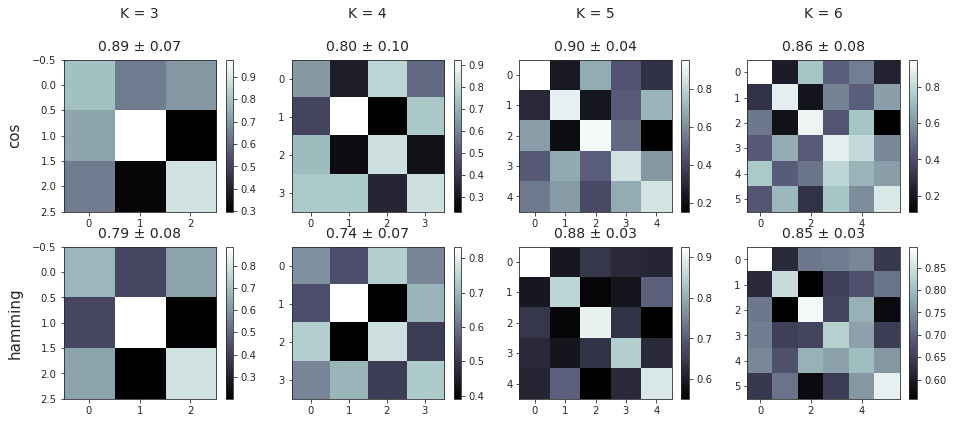

In [24]:
fig, axes = create_figure(2, 4, (13.5, 5.8))

for i, (lbl, d) in enumerate({'cos': scores_cos, 'hamming': scores_ham}.items()):
    for ax, (k, s) in zip(axes[i].flat, d.items()):
        im = ax.imshow(s, cmap='bone')#, vmin=0, vmax=1)
        plt.colorbar(im, ax=ax)

        s_diag = np.diag(s)
        
        if i == 0:
            msg = f"K = {k}\n\n"
        else:
            msg = ''
        msg += f"{s_diag.mean():0.2f} ± {s_diag.std():0.2f}"
        ax.set_title(msg, fontsize=14, y=1.02)
        
        if k == list(scores_cos)[0]:
            ax.set_ylabel(lbl, fontsize=15, labelpad=10)
        # ax.invert_yaxis()

plt.show()

## Carto

In [25]:
props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group(skip_align=False)
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group(skip_align=False)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

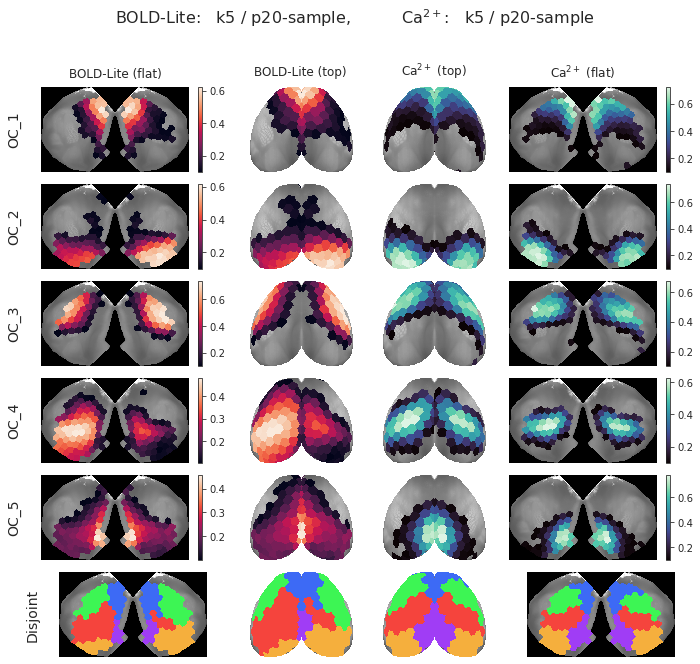

In [26]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
    fig_x=10,
    fig_y=1.5,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [27]:
gr_ca.run_deg.shape

(10, 3, 4, 174)

In [28]:
grp_deg_bold = bn.nanmean(bn.nanmean(bn.nanmean(gr_bold.run_deg, 2), 1), 0)
grp_deg_ca = bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_deg, 2), 1), 0)

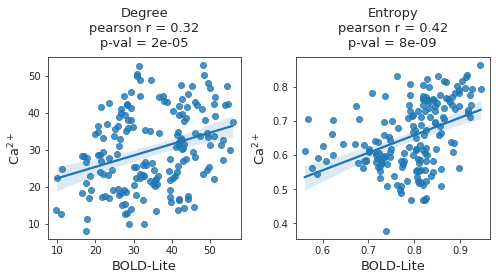

In [29]:
fig, axes = create_figure(1, 2, (7, 4))

rho = sp_stats.pearsonr(grp_deg_bold, grp_deg_ca)
sns.regplot(
    x=grp_deg_bold,
    y=grp_deg_ca,
    ax=axes[0],
)
axes[0].set_ylabel(r'Ca$^{2+}$', fontsize=13)
axes[0].set_xlabel('BOLD-Lite', fontsize=13)
axes[0].set_title(f"Degree\npearson r = {rho[0]:0.2f}\np-val = {rho[1]:1.0e}", fontsize=13, y=1.02)

rho = sp_stats.pearsonr(gr_bold.grp_h, gr_ca.grp_h)
sns.regplot(
    x=gr_bold.grp_h,
    y=gr_ca.grp_h,
    ax=axes[1],
)
axes[1].set_ylabel(r'Ca$^{2+}$', fontsize=13)
axes[1].set_xlabel('BOLD-Lite', fontsize=13)
axes[1].set_title(f"Entropy\npearson r = {rho[0]:0.2f}\np-val = {rho[1]:1.0e}", fontsize=13, y=1.02)

plt.show()

In [31]:
partition = gr_bold.get_disjoint_community(to_vec=True)
df_carto = pd.DataFrame({
    'oc_idx': partition,
    'node': range(len(partition)),
    'entropy': gr_bold.grp_h,
    'degree': grp_deg_bold,
})

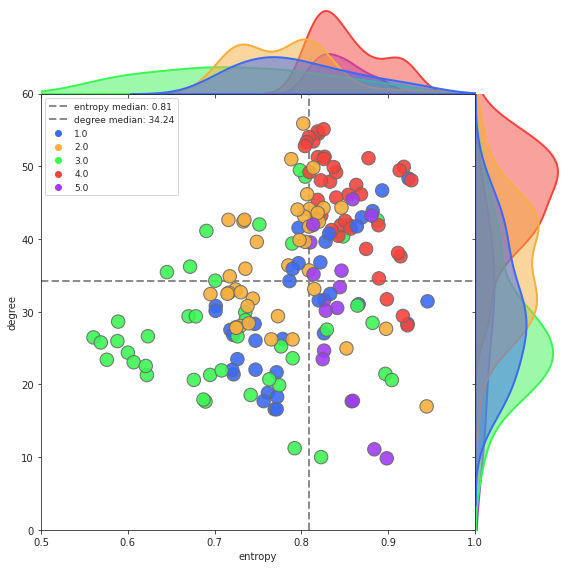

In [34]:
jg = sns.JointGrid(
    data=df_carto,
    x='entropy',
    y='degree',
    hue='oc_idx',
    size=8,
    palette=gr_bold.colors,
    xlim=(0.5, 1.0),
    ylim=(0, 60),
    space=0.0,
)
jg.plot_joint(
    sns.scatterplot,
    hue='oc_idx',
    s=180,
    alpha=0.9,
    edgecolor='dimgrey',
)
jg.plot_marginals(
    sns.kdeplot,
    fill=True,
    alpha=0.5,
    lw=2,
)
_median = df_carto['entropy'].median()
jg.ax_joint.axvline(
    x=_median,
    ls='--',
    lw=2,
    alpha=1.0,
    c=sns.color_palette('deep')[7],
    label=f"entropy median: {_median:.2f}",
    zorder=0,
)
_median = df_carto['degree'].median()
jg.ax_joint.axhline(
    y=_median,
    ls='--',
    lw=2,
    alpha=1.0,
    c=sns.color_palette('deep')[7],
    label=f"degree median: {_median:.2f}",
    zorder=0,
)
jg.ax_joint.legend(loc='upper left', prop={'size': 9})
plt.show()

In [35]:
partition = gr_ca.get_disjoint_community(to_vec=True)
df_carto = pd.DataFrame({
    'oc_idx': partition,
    'node': range(len(partition)),
    'entropy': gr_ca.grp_h,
    'degree': grp_deg_ca,
})

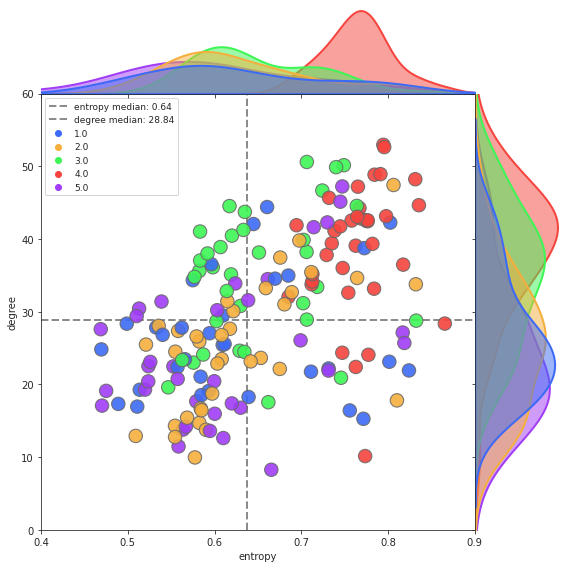

In [37]:
jg = sns.JointGrid(
    data=df_carto,
    x='entropy',
    y='degree',
    hue='oc_idx',
    size=8,
    palette=gr_bold.colors,
    xlim=(0.4, 0.9),
    ylim=(0, 60),
    space=0.0,
)
jg.plot_joint(
    sns.scatterplot,
    hue='oc_idx',
    s=180,
    alpha=0.9,
    edgecolor='dimgrey',
)
jg.plot_marginals(
    sns.kdeplot,
    fill=True,
    alpha=0.5,
    lw=2,
)
_median = df_carto['entropy'].median()
jg.ax_joint.axvline(
    x=_median,
    ls='--',
    lw=2,
    alpha=1.0,
    c=sns.color_palette('deep')[7],
    label=f"entropy median: {_median:.2f}",
    zorder=0,
)
_median = df_carto['degree'].median()
jg.ax_joint.axhline(
    y=_median,
    ls='--',
    lw=2,
    alpha=1.0,
    c=sns.color_palette('deep')[7],
    label=f"degree median: {_median:.2f}",
    zorder=0,
)
jg.ax_joint.legend(loc='upper left', prop={'size': 9})
plt.show()

## OLD (Ignore Below)

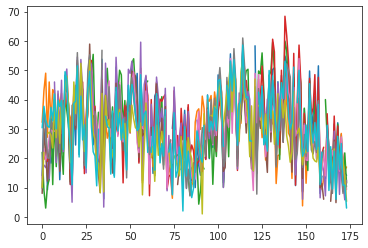

In [272]:
plt.plot(df.values.T);

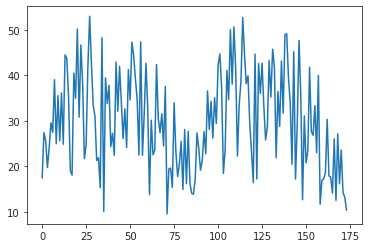

In [273]:
plt.plot(bn.nanmean(df.values, 0));

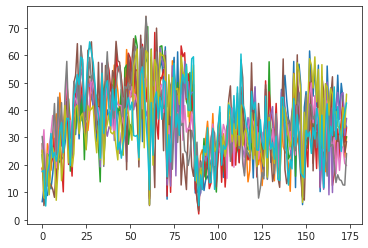

In [284]:
plt.plot(df.values.T);

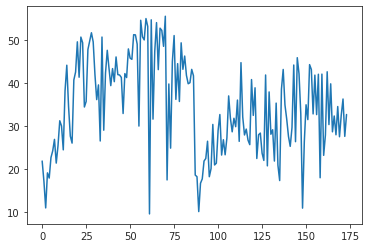

In [285]:
plt.plot(bn.nanmean(df.values, 0));

### Membership plot: individuals

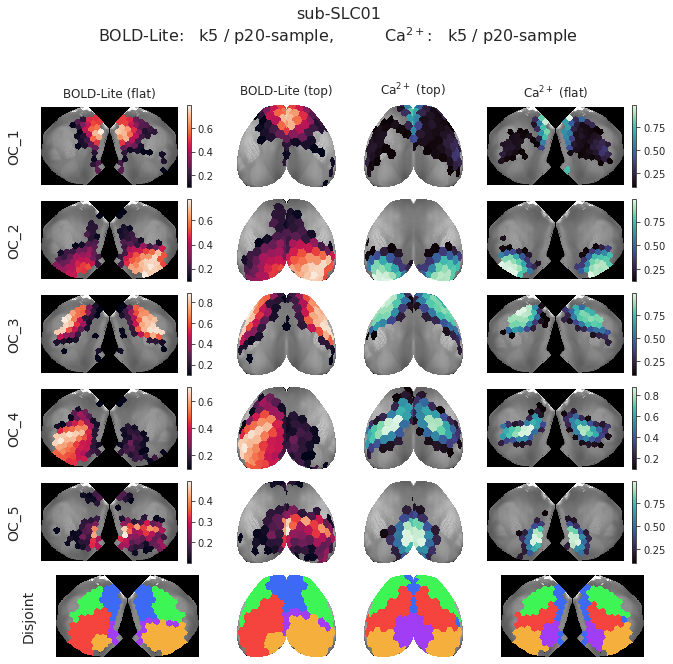

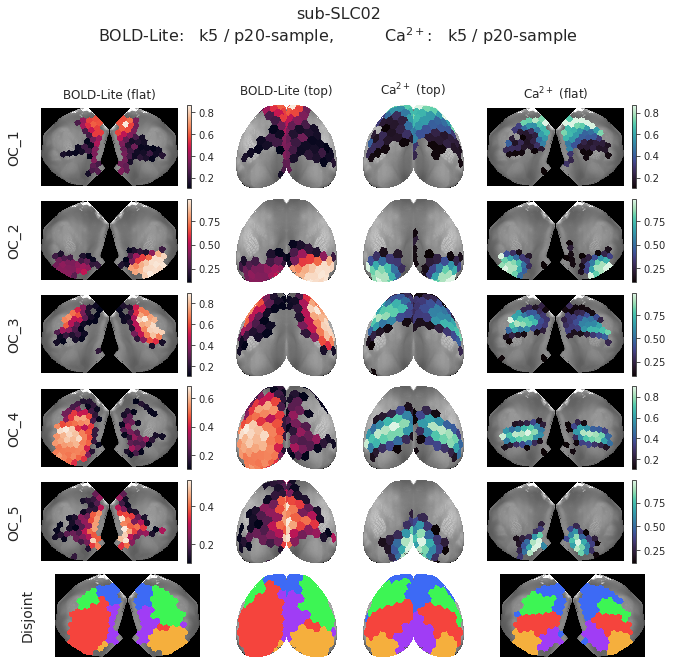

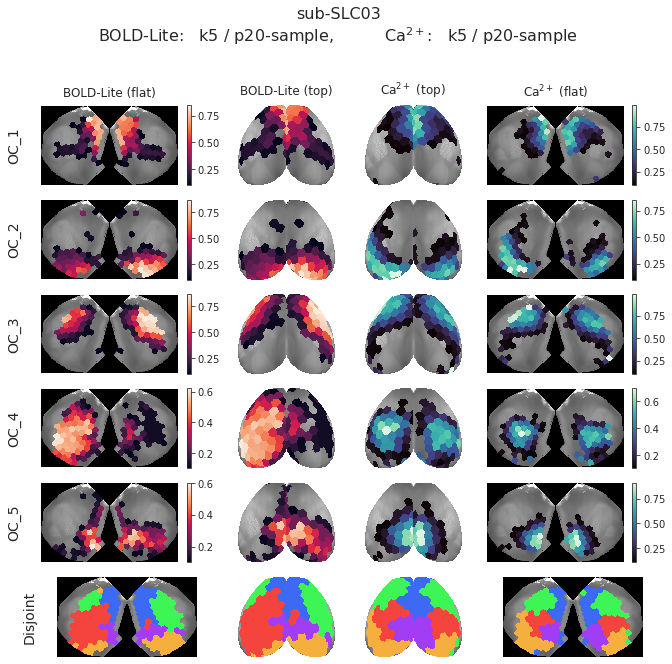

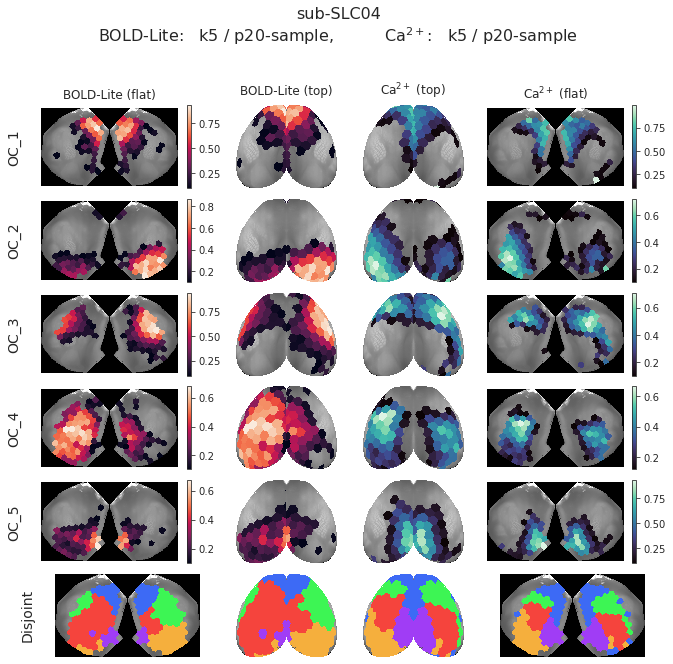

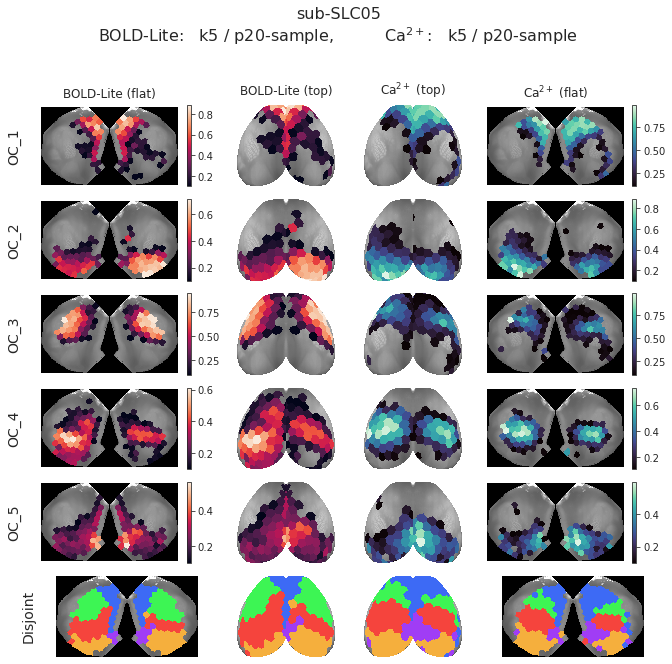

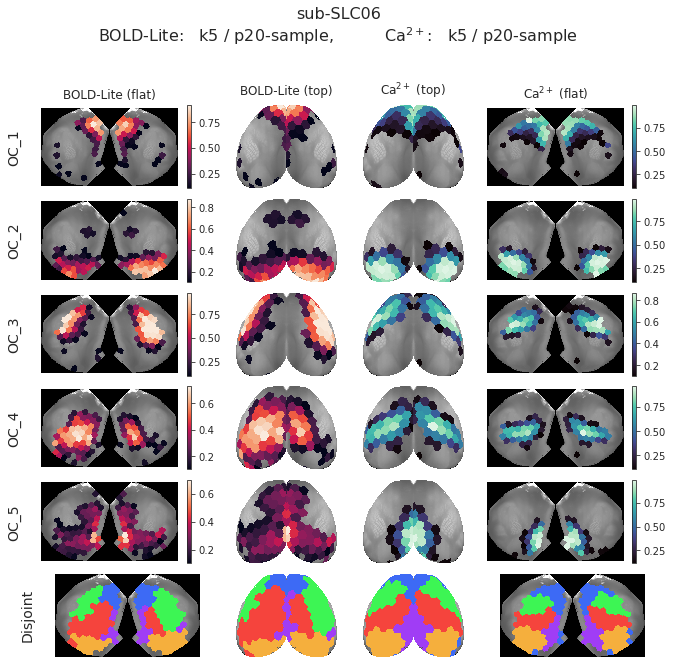

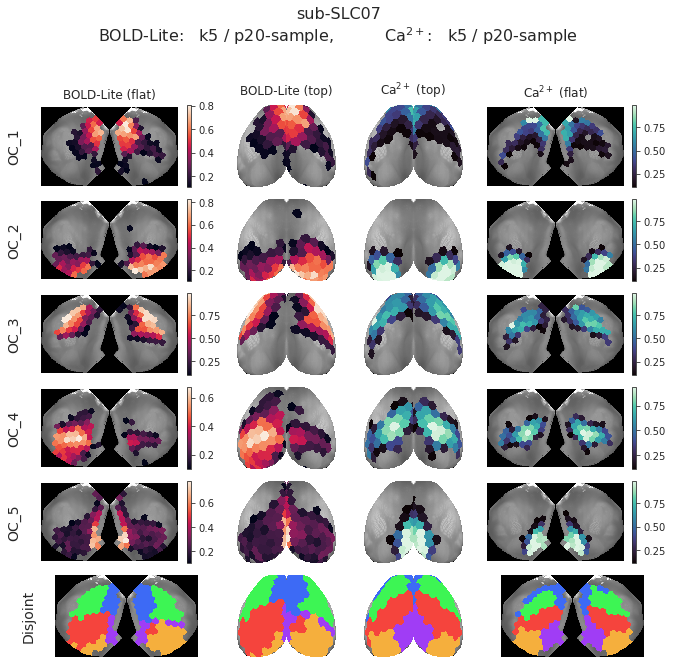

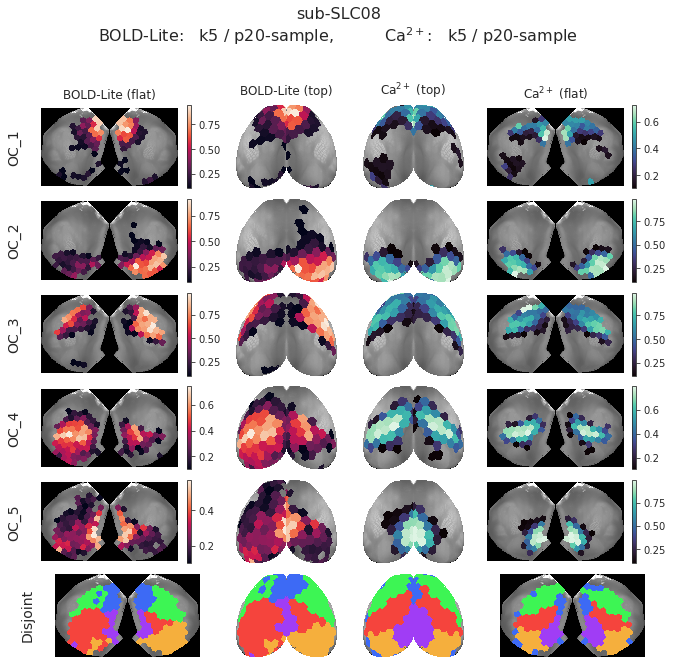

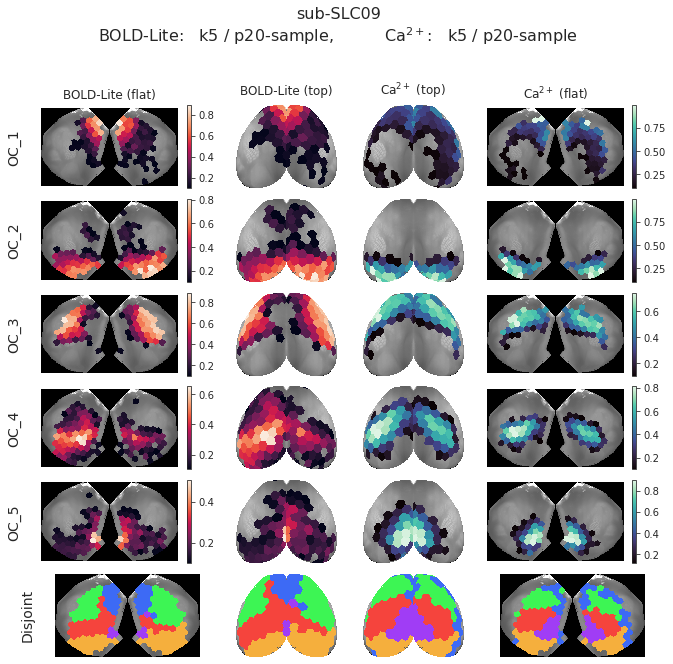

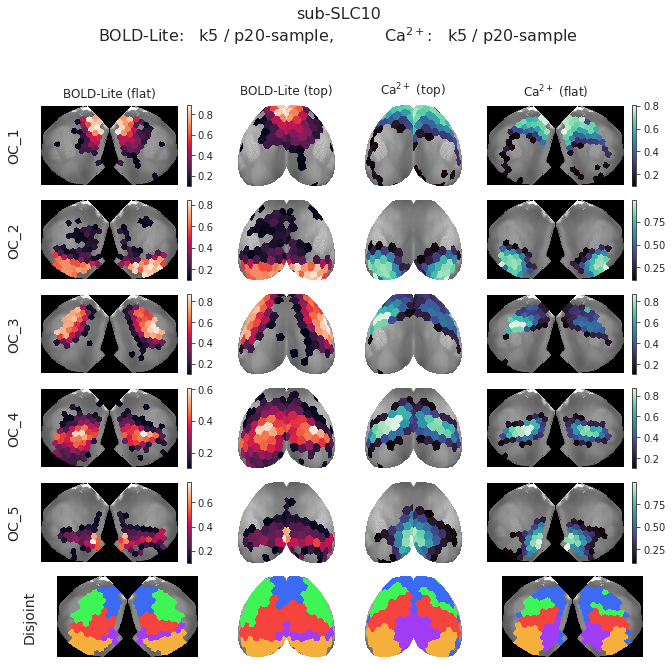

In [11]:
for i, sub in enumerate(mice.cfg.sub_ids):
    proj_ca = gr_ca.project_vec(output_ca['pi'][i])
    proj_bold = gr_bold.project_vec(output_bold['pi'][i])

    fig, _ = gr_ca.show(
        proj_bold, proj_ca,
        labels=('BOLD-Lite', r'Ca$^{2+}$'),
        cmaps=('rocket', 'mako'),
        display=False,
        h_ratio=1.0,
        fig_x=9.5,
        fig_y=1.5,
    )
    sup = f'sub-SLC{sub:02d}\n'
    sup += f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
    sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
    sup = fig.suptitle(sup, fontsize=16, y=1.02)
    
    display(fig)

### Entropy plot: individuals

In [12]:
h_bold = sp_stats.entropy(output_bold['pi'], axis=-2) / np.log(output_bold['pi'].shape[-2])
hr_bold = sp_stats.rankdata(h_bold, axis=-1)
proj_h_bold = gr_bold.project_vec(h_bold, add_disjoint=False)
proj_hr_bold = gr_bold.project_vec(hr_bold, add_disjoint=False)

h_ca = sp_stats.entropy(output_ca['pi'], axis=-2) / np.log(output_ca['pi'].shape[-2])
hr_ca = sp_stats.rankdata(h_ca, axis=-1)
proj_h_ca = gr_ca.project_vec(h_ca, add_disjoint=False)
proj_hr_ca = gr_ca.project_vec(hr_ca, add_disjoint=False)

Entropy: sub-SLC01

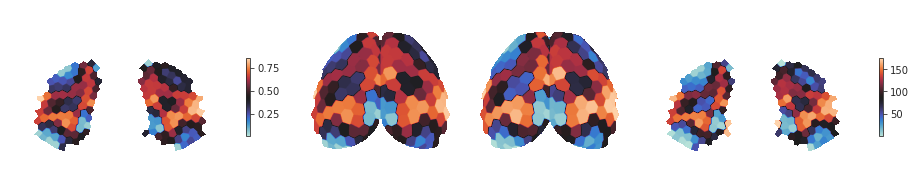

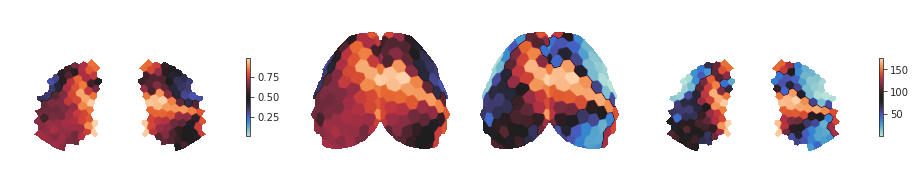

--------------------------------------------------------------------------------

Entropy: sub-SLC02

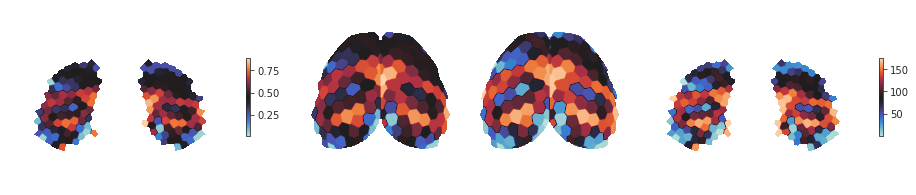

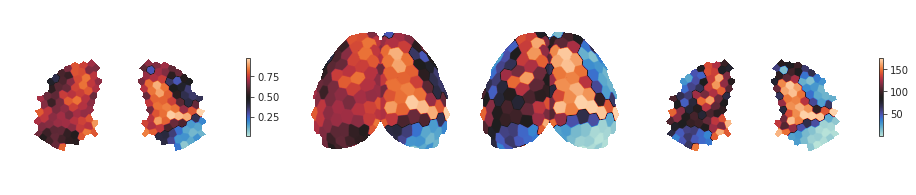

--------------------------------------------------------------------------------

Entropy: sub-SLC03

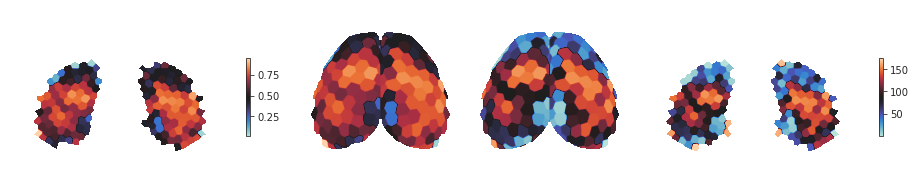

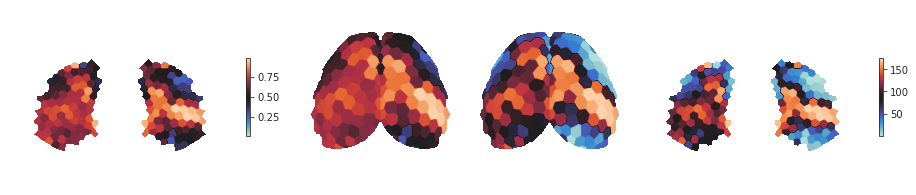

--------------------------------------------------------------------------------

Entropy: sub-SLC04

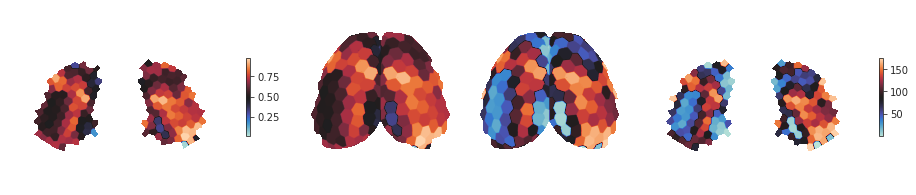

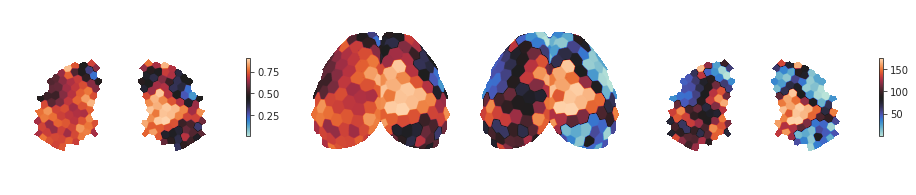

--------------------------------------------------------------------------------

Entropy: sub-SLC05

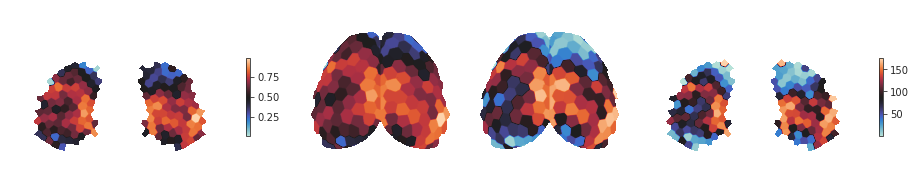

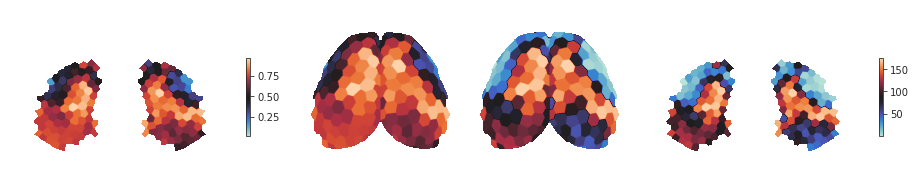

--------------------------------------------------------------------------------

Entropy: sub-SLC06

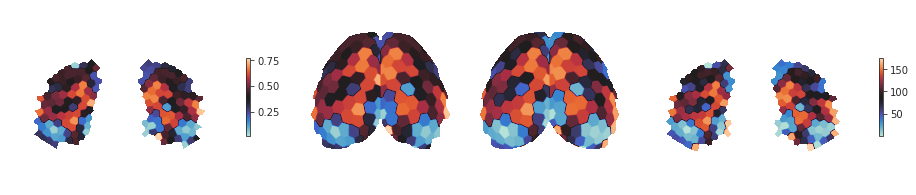

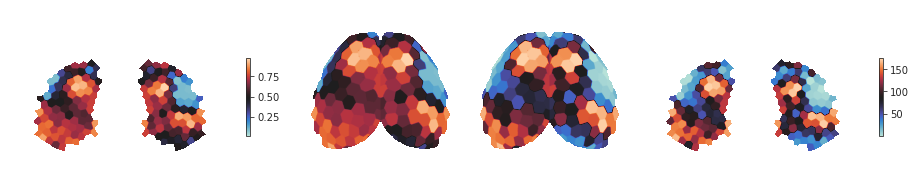

--------------------------------------------------------------------------------

Entropy: sub-SLC07

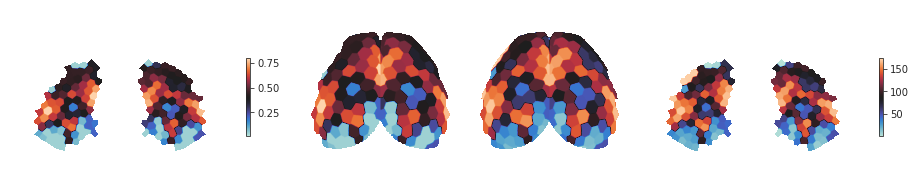

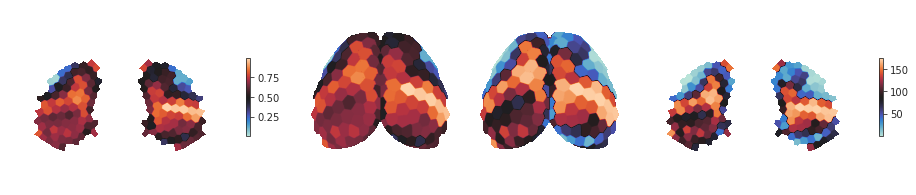

--------------------------------------------------------------------------------

Entropy: sub-SLC08

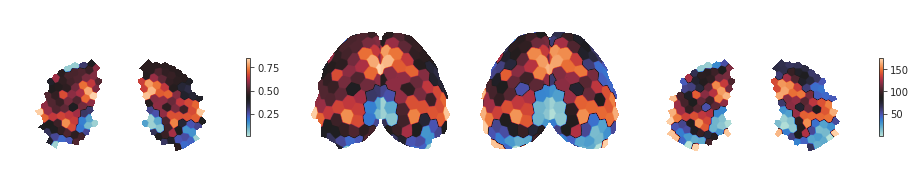

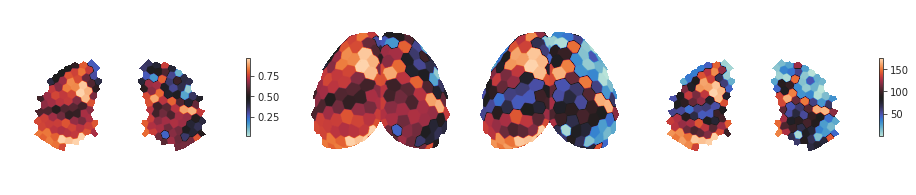

--------------------------------------------------------------------------------

Entropy: sub-SLC09

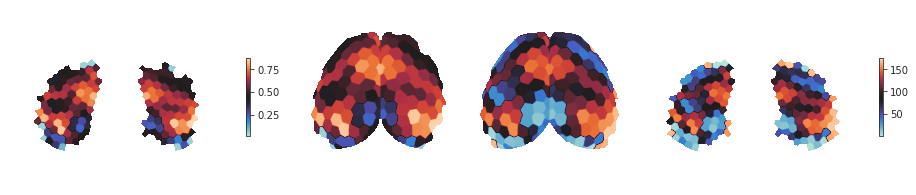

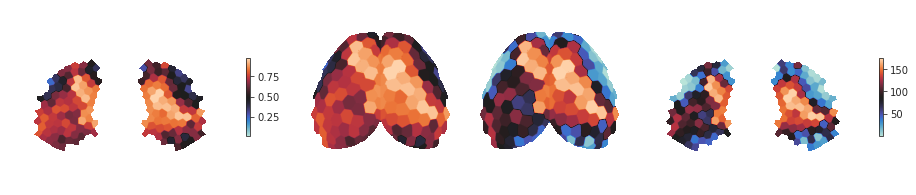

--------------------------------------------------------------------------------

Entropy: sub-SLC10

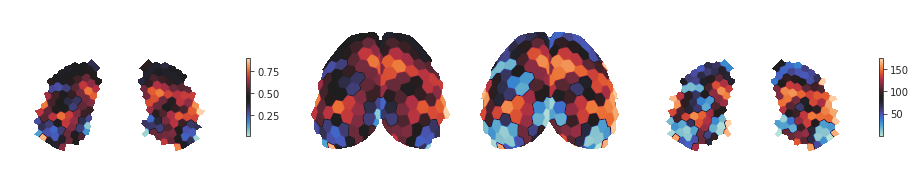

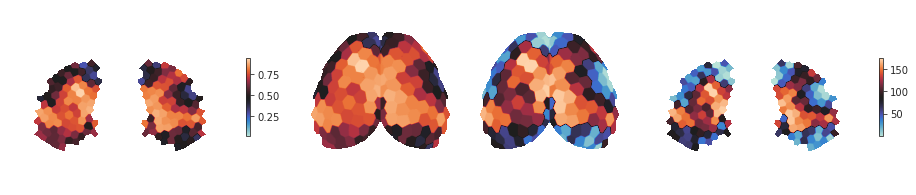

--------------------------------------------------------------------------------

In [13]:
for sub in mice.cfg.sub_ids:
    print(f"Entropy: sub-SLC{sub:02d}")
    show_h(proj_h_ca, proj_hr_ca, sub - 1)
    show_h(proj_h_bold, proj_hr_bold, sub - 1)
    print('-' * 80)
    print('\n')

## K = 6

In [9]:
props_base = {
    'num_k': 6,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'verbose': False,
}
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

bins = np.linspace(0.2, 1.0, 5)
statistic = mk_statistic_fn(bins, False)

In [10]:
# Group results
gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca)
group_ca = gr_ca.fit_group(skip_align=False)

gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold)
group_bold = gr_bold.fit_group(skip_align=False)

# Apply statistic
output_ca = statistic(group_ca['gam_run'])
output_bold = statistic(group_bold['gam_run'])

gr_ca.pi = output_ca['pi_avg']
gr_bold.pi = output_bold['pi_avg']

# Proj
proj_ca = gr_ca.project_vec()
proj_bold = gr_bold.project_vec()

Warning! sub-SLC03_ses-1 was not fit.  Moving on . . .

Warning! sub-SLC03_ses-1 was not fit.  Moving on . . .

Warning! sub-SLC03_ses-1 was not fit.  Moving on . . .

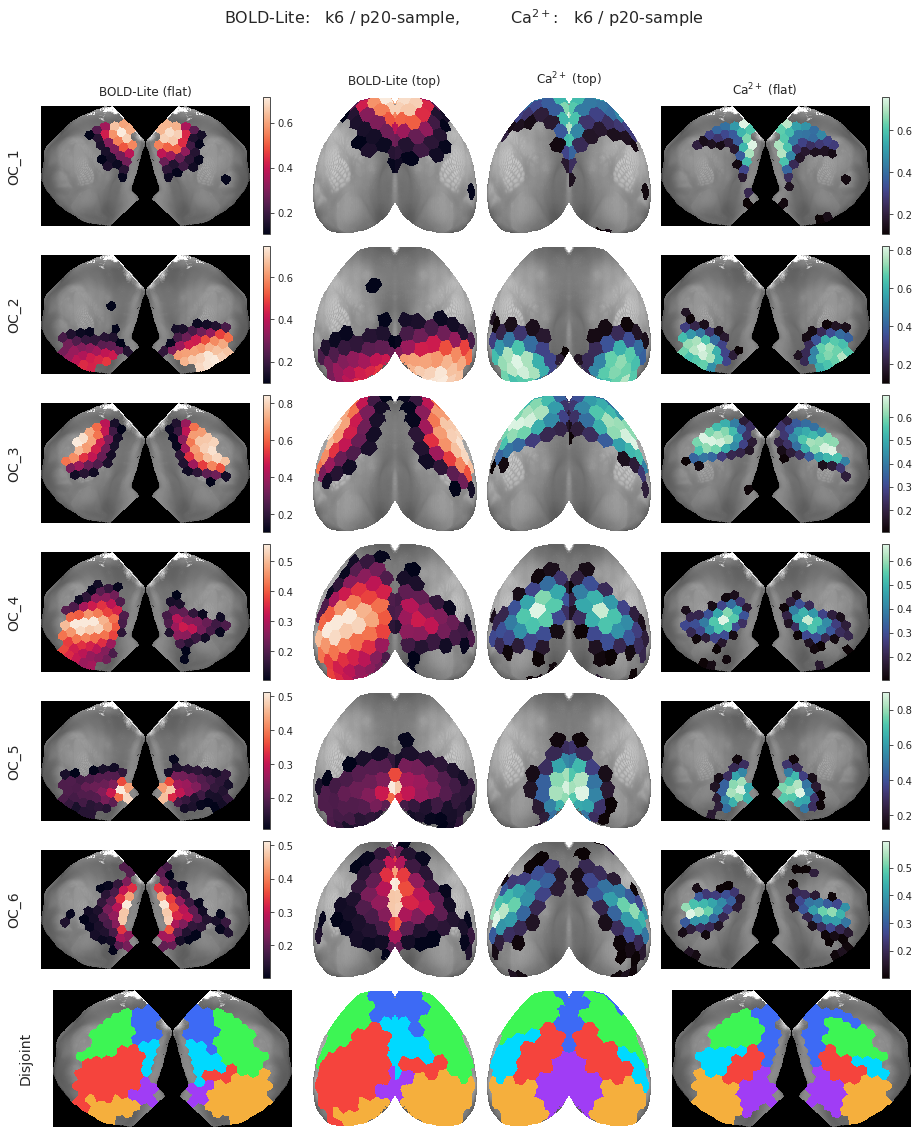

In [11]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

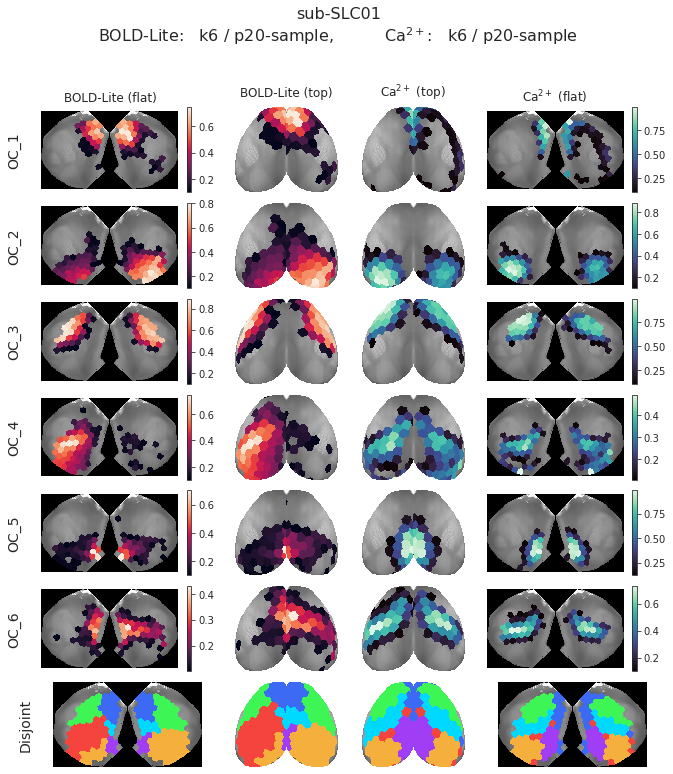

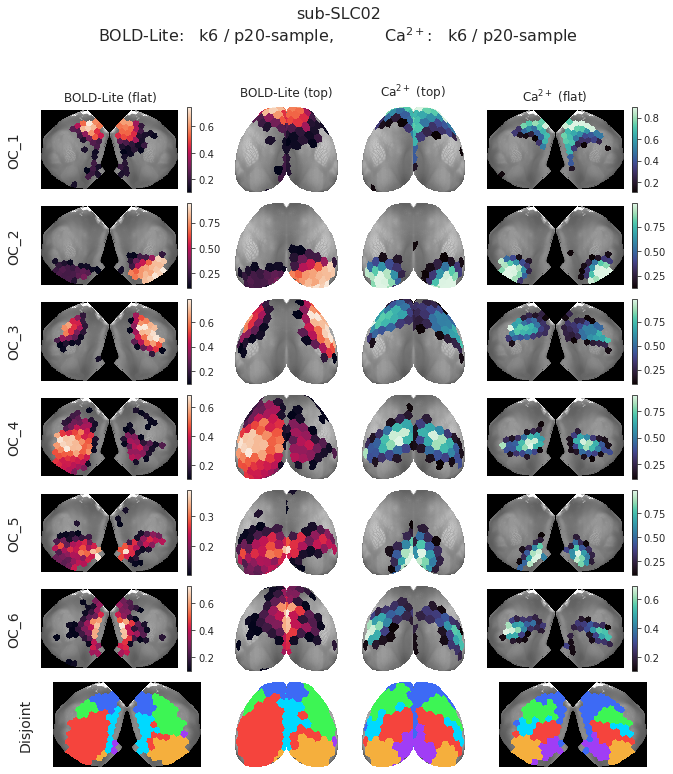

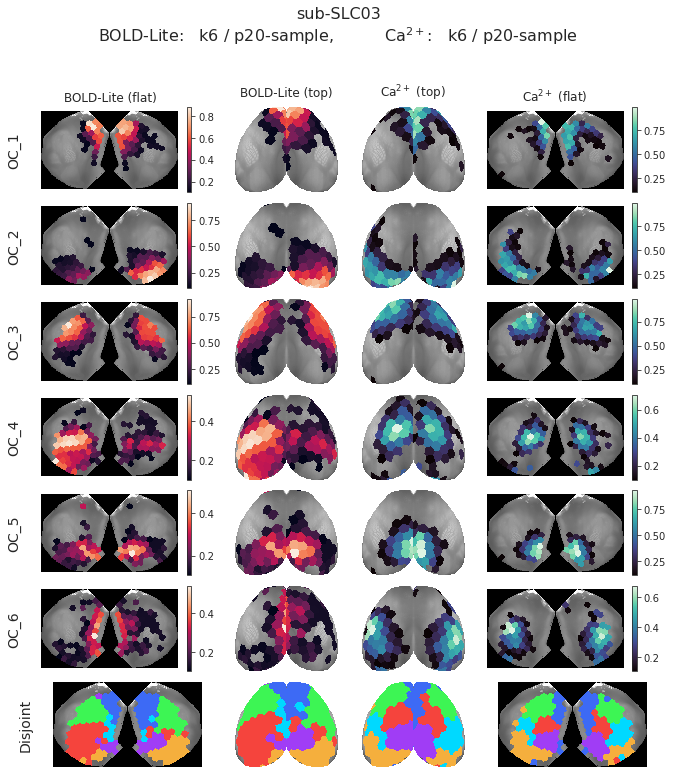

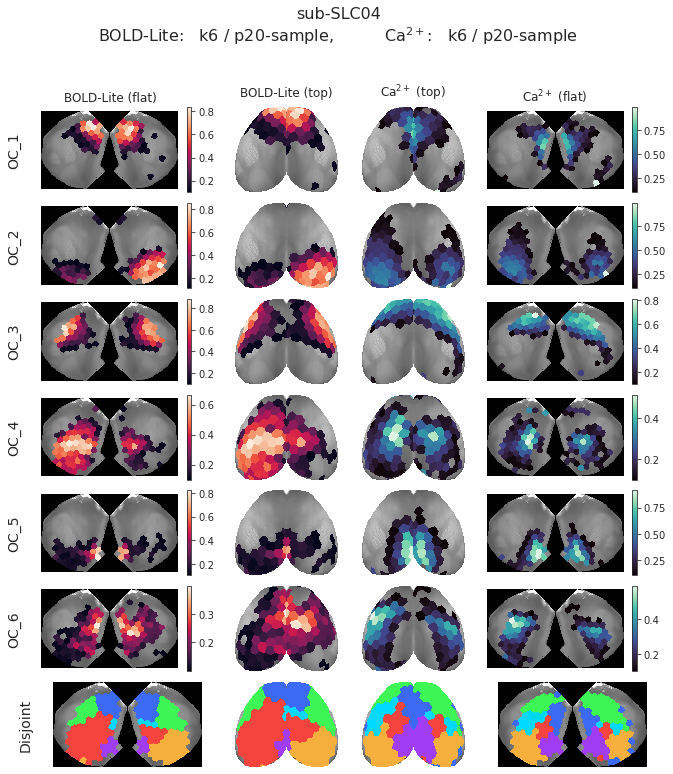

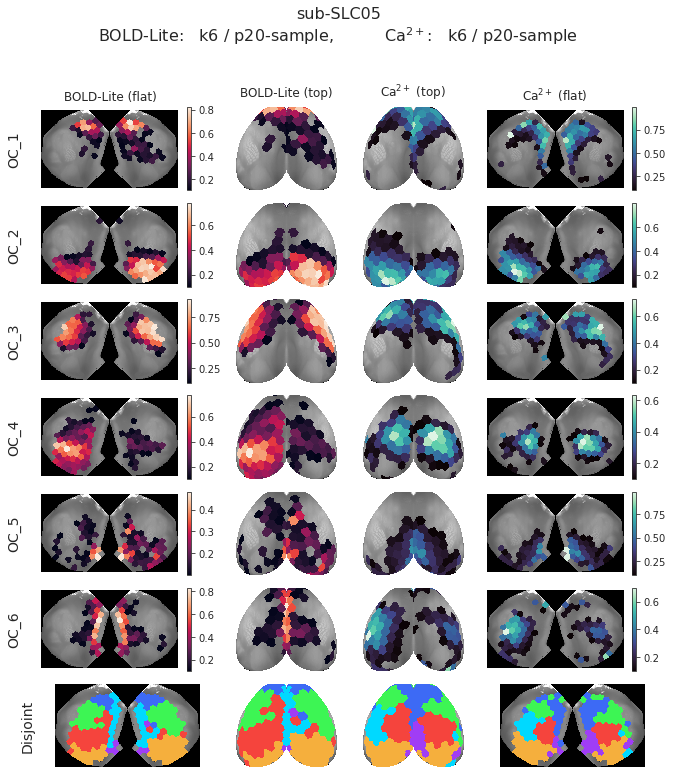

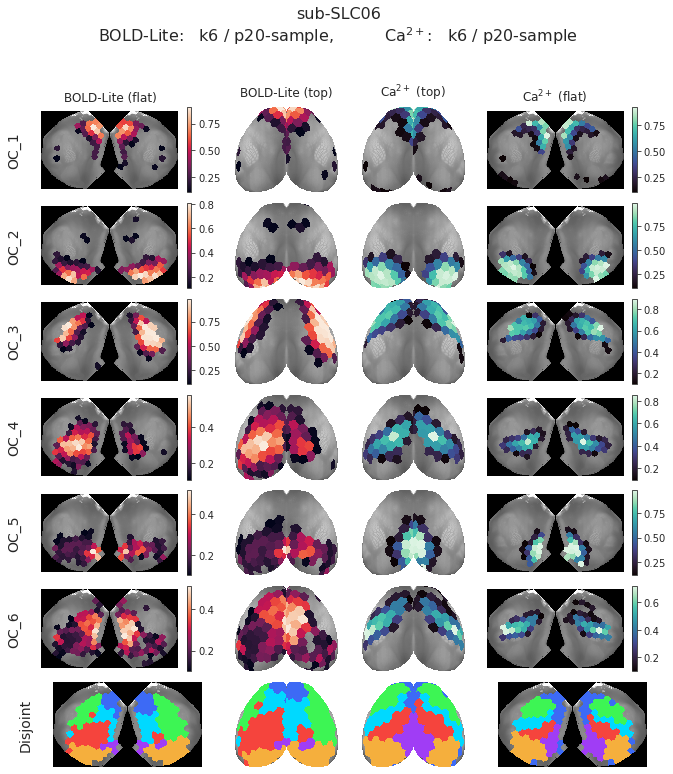

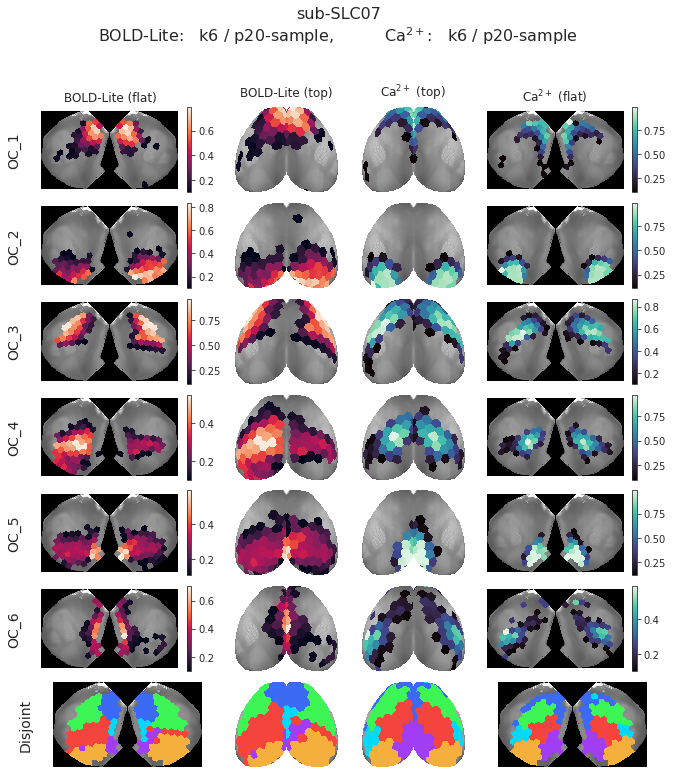

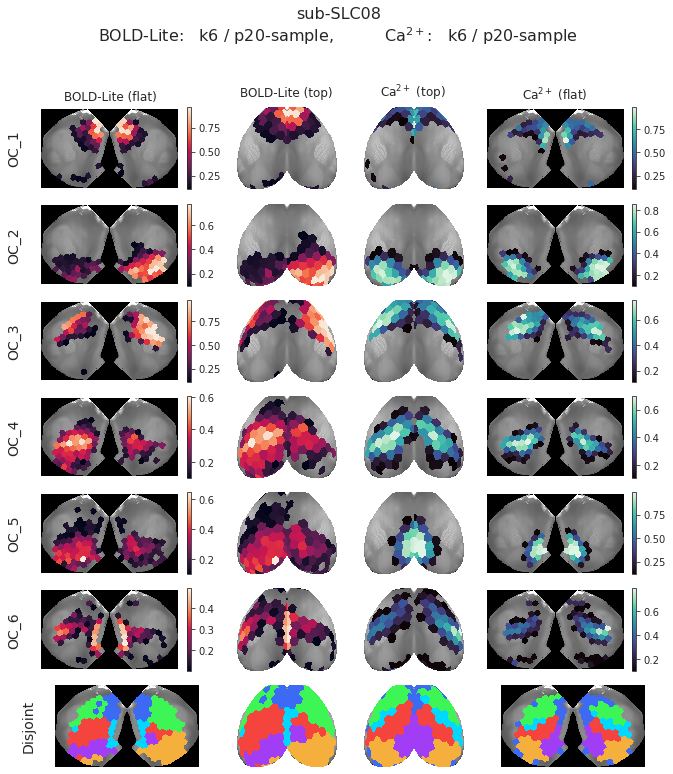

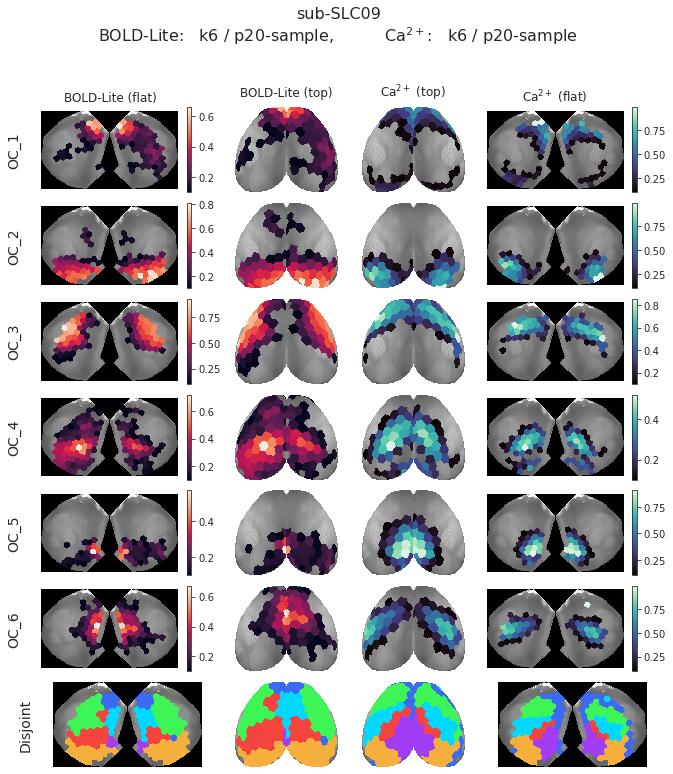

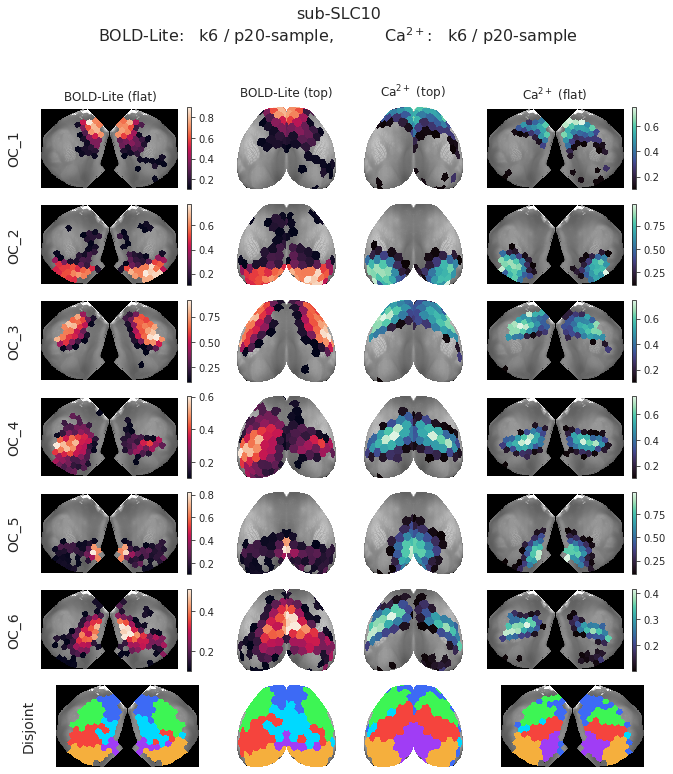

In [12]:
for i, sub in enumerate(mice.cfg.sub_ids):
    proj_ca = gr_ca.project_vec(output_ca['pi'][i])
    proj_bold = gr_bold.project_vec(output_bold['pi'][i])

    fig, _ = gr_ca.show(
        proj_bold, proj_ca,
        labels=('BOLD-Lite', r'Ca$^{2+}$'),
        cmaps=('rocket', 'mako'),
        display=False,
        h_ratio=1.0,
        fig_x=9.5,
        fig_y=1.5,
    )
    sup = f'sub-SLC{sub:02d}\n'
    sup += f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
    sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
    sup = fig.suptitle(sup, fontsize=16, y=1.02)
    
    display(fig)

In [15]:
output_bold['cut'].shape

(10, 6, 4)

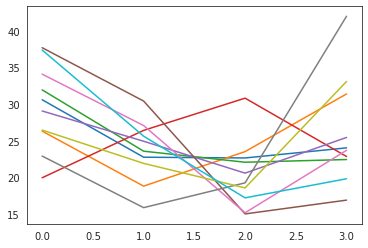

In [40]:
plt.plot(output_bold['cut'][:, 3, :].T);

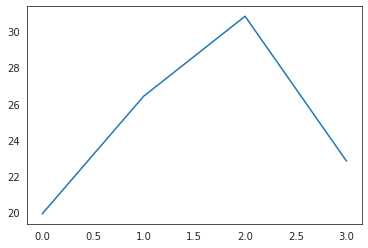

In [41]:
plt.plot(output_bold['cut'][3, 3, :].T);